In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Reading data

In [36]:
ratings = pd.read_csv('./goodbooks-10k-1.0/ratings.csv')
ratings.head(5)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [37]:
ratings.shape

(5976479, 3)

In [38]:
len(ratings.user_id.unique())

53424

I will remove 13424 random users to improve the performance - data are too big to be processed on a sinlge machine.

In [39]:
random.seed(5)

In [40]:
users_to_remove = random.sample(list(ratings.user_id.unique()), 40000)

In [17]:
len(users_to_remove)

40000

In [18]:
ratings = ratings[~ratings.user_id.isin(users_to_remove)]

In [19]:
ratings.shape

(1502613, 3)

Check if there are any NaNs in data

In [20]:
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

Let's see the ratings distribution

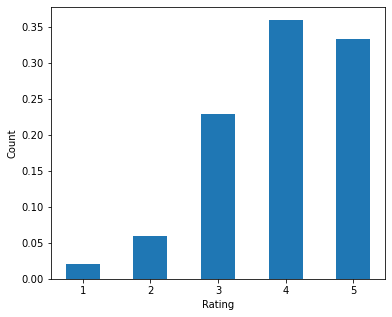

In [21]:
plt.figure(figsize=(6,5))
rating_min = ratings['rating'].min()
rating_max = ratings['rating'].max()
bins_pos = np.arange(rating_min-0.5, rating_max+1.5, 1)
plt.hist(ratings['rating'], bins=bins_pos, density=True, rwidth = 0.5)
plt.xticks(np.arange(rating_min, rating_max+1, 1))
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The most common rating is 4. Now we have to check if there are any books with really few ratings or users who gave very few ratings.

In [22]:
def check_ratings(data, col_name):
    data_grouped = data.groupby(col_name).size()
    plt.figure(figsize=(7,7))
    plt.hist(data_grouped)
    plt.xlabel('Number of ratings')
    plt.ylabel('Count')
    plt.show()
    print(data_grouped.describe())

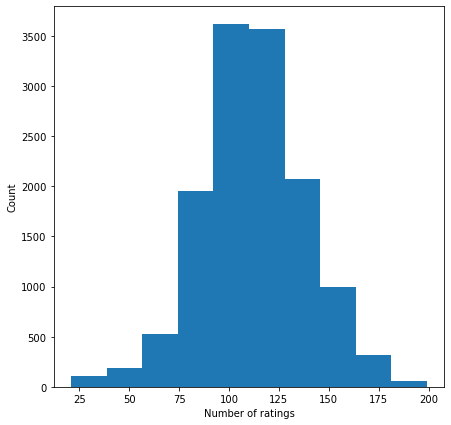

count    13424.000000
mean       111.934818
std         25.972033
min         21.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        199.000000
dtype: float64


In [23]:
check_ratings(ratings,'user_id')

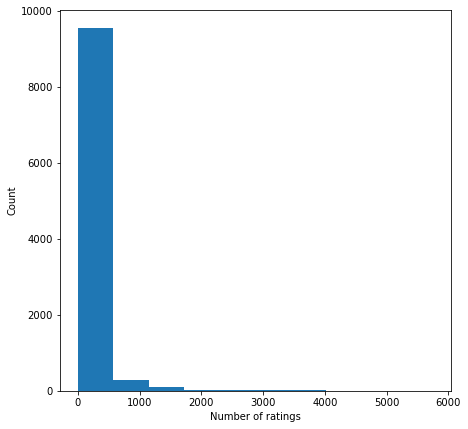

count    10000.000000
mean       150.261300
std        318.758395
min          1.000000
25%         39.000000
50%         62.500000
75%        128.000000
max       5748.000000
dtype: float64


In [24]:
check_ratings(ratings,'book_id')

For the prediction I will use the library Surprise.

In [25]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans
from surprise import accuracy

In [26]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)

In [27]:
X_train, X_test = train_test_split(data, test_size=0.1)

In [28]:
model = KNNWithMeans()

In [29]:
model.fit(X_train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [30]:
test_pred=model.test(X_test)

In [31]:
train_pred = model.test(list(X_train.all_ratings()))

KeyboardInterrupt: 

In [32]:
accuracy.rmse(test_pred)


RMSE: 0.8439


0.843940976545934

In [119]:
list(X_train.all_ratings())

[(0, 0, 3.0),
 (0, 295, 3.0),
 (0, 420, 4.0),
 (0, 28, 4.0),
 (0, 95, 4.0),
 (0, 789, 4.0),
 (0, 862, 5.0),
 (0, 930, 3.0),
 (0, 934, 4.0),
 (0, 940, 3.0),
 (0, 998, 3.0),
 (0, 76, 2.0),
 (0, 674, 3.0),
 (0, 909, 4.0),
 (0, 1095, 3.0),
 (0, 1113, 4.0),
 (0, 1013, 3.0),
 (0, 847, 4.0),
 (0, 1199, 3.0),
 (0, 1217, 4.0),
 (0, 1246, 4.0),
 (0, 1355, 3.0),
 (0, 963, 4.0),
 (0, 1387, 4.0),
 (0, 275, 3.0),
 (0, 92, 3.0),
 (0, 409, 3.0),
 (0, 166, 4.0),
 (0, 77, 4.0),
 (0, 1562, 5.0),
 (0, 444, 3.0),
 (0, 1224, 3.0),
 (0, 1167, 3.0),
 (0, 1333, 4.0),
 (0, 267, 3.0),
 (0, 1670, 3.0),
 (0, 1140, 3.0),
 (0, 951, 3.0),
 (0, 1705, 4.0),
 (0, 1721, 4.0),
 (0, 94, 4.0),
 (0, 1745, 4.0),
 (0, 1749, 3.0),
 (0, 1654, 4.0),
 (0, 212, 3.0),
 (0, 1824, 4.0),
 (0, 864, 3.0),
 (0, 1897, 4.0),
 (0, 1925, 3.0),
 (0, 1166, 3.0),
 (0, 992, 5.0),
 (0, 941, 4.0),
 (0, 1639, 4.0),
 (0, 2079, 4.0),
 (0, 2161, 4.0),
 (0, 545, 4.0),
 (0, 800, 3.0),
 (0, 1230, 3.0),
 (0, 1437, 4.0),
 (0, 1054, 4.0),
 (0, 726, 4.0),
 (0